In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.signal import lfilter
import statsmodels.api as sm
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

### Model: two companies y1 and y2 compete in the market "f". Their market shares are measured with an error and total market size f(t) is unobservable.
##### y1(t) = 0.5 f(t) + e1(t)   --- observed
##### y2(t) = 0.5 f(t) + e2(t)   --- observed
##### f(t) = 1.0 + 0.75 f(t-1) - 0.5 f(t-2) + ef(t)   --- hidden

In [12]:
# True model parameters
true_y_coef = np.r_[0.5, 0.5]
true_y_var = np.r_[1.0, 1.0]

true_f_const = 1.0
true_f_coef = np.r_[0.75, -0.5]
true_f_var = np.r_[1.0]

In [13]:
# Simulate a time series
data = pd.DataFrame(index = perdelta(date(2006, 1, 1), date(2016, 1, 31), timedelta(days = 1)))
n_obs = len(data.index)

f_disturbances = np.random.normal(0, true_f_var[0]**0.5, size=(n_obs,))
f = [true_f_const, true_f_coef[0] * true_f_const]
for ef in f_disturbances:
    f.append(true_f_const + true_f_coef[0] * f[-1] + true_f_coef[1] * f[-2] + ef)
f = np.array(f[2:]).reshape(-1,1)
    
y_disturbances = np.random.normal([0,0], true_y_var**0.5, size=(n_obs,2))
endog = np.multiply(f, true_y_coef) + y_disturbances

data['y1'] = pd.DataFrame(endog)[0].values
data['y2'] = pd.DataFrame(endog)[1].values

### If there were no measurement errors, then y1 + y2 = f(t) would always hold.
### Thus, the model will rely on constraint y_coef_1 + y_coef_2 = 1

In [14]:
# Construct the model
class Custom_DLM(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        
        # Model order
        k_states = 2
        k_posdef = 1
        initialization='stationary'
        
        # Initialize the state space model
        super(Custom_DLM, self).__init__(endog, k_states=k_states, k_posdef=k_posdef, initialization=initialization)

        # Setup the fixed components of the state space representation
        self.ssm['design'] = [[0, 0], [0, 0]]
        self.ssm['transition'] = [[0, 0], [1, 0]]
        self.ssm['state_intercept'] = [[0], [0]]
        self.ssm['selection'] = [[1], [0]]
   
    # Specify parameter names
    @property
    def param_names(self):
        return ['y_coef', 'y_var_1', 'y_var_2', 'f_coef_0', 'f_coef_1', 'f_coef_2', 'f_var']
    
    # Specify start parameters
    @property
    def start_params(self):
        return [0, 1, 1, 0, 0, 0, 1]
    
    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(Custom_DLM, self).update(params, transformed, **kwargs)

        self.ssm['design', 0, 0] = params[0]
        self.ssm['design', 1, 0] = 1.0 - params[0]
        
        self.ssm['obs_cov', 0, 0] = params[1]
        self.ssm['obs_cov', 1, 1] = params[2]
        
        self.ssm['state_intercept', 0, 0] = params[3]
                
        self.ssm['transition', 0, 0] = params[4]
        self.ssm['transition', 0, 1] = params[5]
        
        self.ssm['state_cov', 0, 0] = params[6]

In [15]:
# Create and fit the model
model = Custom_DLM(data)
res = model.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:           ['y1', 'y2']   No. Observations:                 3682
Model:                     Custom_DLM   Log Likelihood              -11443.093
Date:                Mon, 12 Mar 2018   AIC                          22900.185
Time:                        20:34:14   BIC                          22943.664
Sample:                    01-01-2006   HQIC                         22915.662
                         - 01-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y_coef         0.5109      0.008     66.348      0.000       0.496       0.526
y_var_1        1.0261      0.033     31.342      0.000       0.962       1.090
y_var_2        0.9821      0.030     32.292      0.0

In [16]:
# Perform prediction and forecasting
predict = res.get_prediction()
forecast = res.get_forecast('2017')

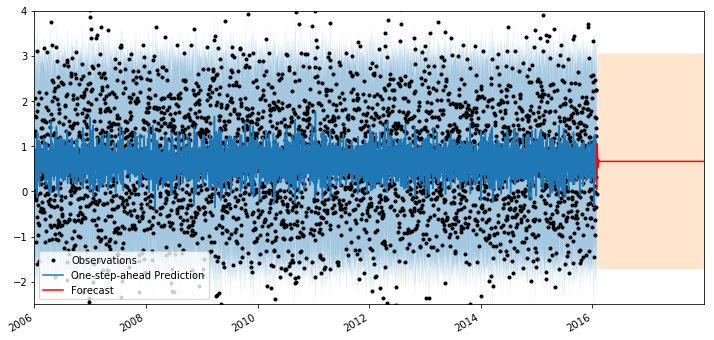

In [17]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot the results
data['y1'].plot(ax=ax, style='k.', label='Observations')

# Predicted series
predict.predicted_mean['y1'].plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)[['lower y1', 'upper y1']]
ax.fill_between(predict_ci.index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.4)

# Forecasted series
forecast.predicted_mean['y1'].plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()[['lower y1', 'upper y1']]
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.2)

# Cleanup the image
ax.set_ylim((-2.5, 4))
legend = ax.legend(loc='lower left')